In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import label encoder 
from sklearn import preprocessing 

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor # multilayer perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pylab
import math
import cv2

%matplotlib inline

In [2]:
def readyTheDataset():
    data = pd.read_csv("Dataset.csv", encoding='cp1252')
    data.columns = ['name', 'carspaces', 'bedrooms', 'bathrooms', 'floorarea', 'landsize', 'waterfront', 'location', 'price']
    
    display(data)
    
    return data

In [3]:
def findDuplicates(data):
    duplicates = data[data['name'].duplicated() == True]
    if(len(duplicates)):
        print('There are ', len(duplicates), ' duplicates in the dataset.')
    else:
        print('There are no duplicates in the dataset.')
    
def removeDuplicates(data):
    data.drop_duplicates(subset = ["name"], keep = 'first', inplace = True) 
    
    return data

In [4]:
def displayList(list, string):
    list.sort()
    print('There are total of ', len(list), ' provinces listed in the data.')
    
    list=pd.DataFrame(list, columns=[string]) 
    display(list)

In [5]:
def labelEncode(data, string):
    label_encoder = preprocessing.LabelEncoder() 
    
    data[string]= label_encoder.fit_transform(data[string]) 
    return data

In [6]:
def displayHeatMap(data):
    # calculate the correlation matrix
    data = data.astype(float)
    corr = data.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')
    
    return data

In [7]:
def displayVFI(data):
    # the VFI does expect a constant term in the data, so we need to add one using the add_constant method
    X1 = sm.tools.add_constant(data)

    # create the series for both
    series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)

    # display the series
    print('Current VFI')
    display(series_before)

In [8]:
def displayBoxPlot():
    fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(nrows= 2, ncols = 4, figsize = (24,13))
    sns.boxplot(ax = ax1, y = 'carspaces', data = data, color = 'limegreen')
    sns.boxplot(ax = ax2, y = 'bedrooms', data = data, color = 'pink')
    sns.boxplot(ax = ax3, y = 'bathrooms', data = data, color = 'limegreen')
    sns.boxplot(ax = ax4, y = 'floorarea', data = data, color = 'pink')
    sns.boxplot(ax = ax5, y = 'landsize', data = data, color = 'limegreen')
    sns.boxplot(ax = ax6, y = 'waterfront', data = data, color = 'pink')
    sns.boxplot(ax = ax7, y = 'location', data = data, color = 'limegreen')
    sns.boxplot(ax = ax8, y = 'price', data = data, color = 'pink')

In [9]:
def removeOutliers(data):
    # filter the data frame to remove the values exceeding 3 standard deviations
    remove_df = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

    # what rows were removed
    data.index.difference(remove_df.index)
    print("Number of outliers found: ", len(data)-len(remove_df))
    display(remove_df)
    return remove_df

In [10]:
def displayDescribe(data):
    # get the summary
    desc_df = data.describe()

    # add the standard deviation metric
    desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
    desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

    # display the summary
    display(desc_df)

In [11]:
def getScore(modelName, model):
    print(modelName)
    print("Train R-Squared: ", model.score(X_train, Y_train))
    print("Test R-Squared: ", model.score(X_test, Y_test))
    print()

In [12]:
def getErrors(modelName, pred):
#     model_pred = 
    print(modelName)
    e = mean_squared_error(pred, Y_test)
    print("Mean Squared Error (MSE): ", e)
    print("Mean Absolute Error (MAE): ", mean_absolute_error(pred, Y_test))
    print("Root Mean Squared Error (RMSE): ", math.sqrt(e))
    print()

In [13]:
def getInterceptCoeff(model):
    # let's grab the coefficient of our model and the intercept for Linear Regression Model
    print("\n The intercept for our model is {:.4}".format(model.intercept_))
    # print('-'*100)

    coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])
    display(coeff_df)

In [14]:
def checkHeterosecdasticity(est):
    # Run the Breusch-Pagan test
    _, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
    print(pval, f_pval)
    print('-'*100)

    # print the results of the test
    if pval > 0.05:
        print("For the Breusch-Pagan's Test")
        print("The p-value was {:.4}".format(pval))
        print("We fail to reject the null hypothesis, so there is no heterosecdasticity.")

    else:
        print("For the Breusch-Pagan's Test")
        print("The p-value was {:.4}".format(pval))
        print("We reject the null hypothesis, so there is heterosecdasticity.")

In [15]:
def checkAutocorr(est, X):
    # calculate the lag, optional
    lag = min(10, (len(X)//5))
    print('The number of lags will be {}'.format(lag))
    print('-'*100)

    # run the Ljung-Box test for no autocorrelation of residuals
    test_results = diag.acorr_ljungbox(est.resid, lags = lag)

    # grab the p-values and the test statistics
    ibvalue, p_val = test_results

    # print the results of the test
    if min(p_val) > 0.05:
        print("The lowest p-value found was {:.4}".format(min(p_val)))
        print("We fail to reject the null hypothesis, so there is no autocorrelation.")
        print('-'*100)
    else:
        print("The lowest p-value found was {:.4}".format(min(p_val)))
        print("We reject the null hypothesis, so there is autocorrelation.")
        print('-'*100)

    # plot autocorrelation
    sm.graphics.tsa.plot_acf(est.resid)
    plt.show()

In [16]:
def getPredict(model, X_test):
    # Get multiple predictions
    y_predict = model.predict(X_test) 

    # Show the first 5 predictions
    print("Price for the first 5 predictions: ")
    for price in y_predict[:5]:
        print(price)

In [17]:
def getDecisionTree(model, names):
    export_graphviz(model, 'tree.dot', feature_names = list(data)[0:7], max_depth = 3)
    
    ! dot -Tpng tree.dot -o tree.png
    
    img = cv2.imread('tree.png')
    plt.figure(figsize = (20, 20))
    plt.imshow(img)
    
# getDecisionTree(modelDT, list(data)[0:7])

In [18]:
data = readyTheDataset()

,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.0,2.0,3.0,150.0,173.0,1.0,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.0,3.0,2.0,80.0,291.0,1.0,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.0,3.0,2.0,385.4,1500.0,1.0,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.0,5.0,5.0,360.0,462.0,0.0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.0,4.0,3.0,103.0,60.0,0.0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
377,3-bedroom Single Detached House and Lot in Dan...,1.0,3.0,2.0,77.0,80.0,0.0,Danao,3111250.0
378,House and lot for sale in Talamban Classy Village,1.0,4.0,4.0,360.0,193.0,1.0,Talamban,12000000.0
379,Modern 4 Bedroom Duplex House 4 Sale,2.0,3.0,2.0,120.0,98.0,0.0,Mandaue,4800000.0
380,Townhouse for Sale at Holy Family Village 2,2.0,3.0,3.0,86.0,86.0,0.0,Cebu,10000000.0


In [19]:
findDuplicates(data)
data = removeDuplicates(data) # leaving 1 observation of each duplicates
findDuplicates(data)
data

There are  27  duplicates in the dataset.
There are no duplicates in the dataset.


,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.0,2.0,3.0,150.0,173.0,1.0,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.0,3.0,2.0,80.0,291.0,1.0,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.0,3.0,2.0,385.4,1500.0,1.0,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.0,5.0,5.0,360.0,462.0,0.0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.0,4.0,3.0,103.0,60.0,0.0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
377,3-bedroom Single Detached House and Lot in Dan...,1.0,3.0,2.0,77.0,80.0,0.0,Danao,3111250.0
378,House and lot for sale in Talamban Classy Village,1.0,4.0,4.0,360.0,193.0,1.0,Talamban,12000000.0
379,Modern 4 Bedroom Duplex House 4 Sale,2.0,3.0,2.0,120.0,98.0,0.0,Mandaue,4800000.0
380,Townhouse for Sale at Holy Family Village 2,2.0,3.0,3.0,86.0,86.0,0.0,Cebu,10000000.0


In [20]:
# check for null values
display(data.isnull().any())

name          False
carspaces      True
bedrooms       True
bathrooms      True
floorarea      True
landsize       True
waterfront     True
location      False
price          True
dtype: bool

In [21]:
# filling in the null values
data[['carspaces']] = data[['carspaces']].fillna(data['carspaces'].mean())
data[['bedrooms']] = data[['bedrooms']].fillna(data['bedrooms'].mean())
data[['bathrooms']] = data[['bathrooms']].fillna(data['bathrooms'].mean())
data[['floorarea']] = data[['floorarea']].fillna(data['floorarea'].mean())
data[['landsize']] = data[['landsize']].fillna(data['landsize'].mean())
data[['waterfront']] = data[['waterfront']].fillna('0')
display(data.isnull().any())

name          False
carspaces     False
bedrooms      False
bathrooms     False
floorarea     False
landsize      False
waterfront    False
location      False
price          True
dtype: bool

In [22]:
# now, the price has the only column that contains null values
# we will be remove those rows with null prices since we are predicting the prices for house sales
data.dropna(axis = 0, how = 'any', inplace = True)
data

,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.0,2.0,3.0,150.0,173.0,1,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.0,3.0,2.0,80.0,291.0,1,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.0,3.0,2.0,385.4,1500.0,1,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.0,5.0,5.0,360.0,462.0,0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.0,4.0,3.0,103.0,60.0,0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
377,3-bedroom Single Detached House and Lot in Dan...,1.0,3.0,2.0,77.0,80.0,0,Danao,3111250.0
378,House and lot for sale in Talamban Classy Village,1.0,4.0,4.0,360.0,193.0,1,Talamban,12000000.0
379,Modern 4 Bedroom Duplex House 4 Sale,2.0,3.0,2.0,120.0,98.0,0,Mandaue,4800000.0
380,Townhouse for Sale at Holy Family Village 2,2.0,3.0,3.0,86.0,86.0,0,Cebu,10000000.0


In [23]:
data.drop('name', axis = 1, inplace = True)
data

,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,2.0,2.0,3.0,150.0,173.0,1,Lapu-Lapu,3800000.0
1,1.0,3.0,2.0,80.0,291.0,1,Argao,7078000.0
2,5.0,3.0,2.0,385.4,1500.0,1,Camotes Island,11900000.0
3,4.0,5.0,5.0,360.0,462.0,0,Lapu-Lapu,52000000.0
4,1.0,4.0,3.0,103.0,60.0,0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...
377,1.0,3.0,2.0,77.0,80.0,0,Danao,3111250.0
378,1.0,4.0,4.0,360.0,193.0,1,Talamban,12000000.0
379,2.0,3.0,2.0,120.0,98.0,0,Mandaue,4800000.0
380,2.0,3.0,3.0,86.0,86.0,0,Cebu,10000000.0


In [24]:
# identify if the location values are all provinces and not repeating 
location_list = data.location.unique()
location_list

array(['Lapu-Lapu', 'Argao', 'Camotes Island', 'Mandaue', 'Cebu',
       'Consolacion', 'Bogo', 'Oslob', 'Talisay', 'Liloan', 'Medellin',
       'Compostela', 'Minglanilla', 'Alcoy', 'Lapu-lapu', 'Cordova',
       'Toledo', 'Talamban', 'Borbon', 'Bantayan', 'Santander', 'Badian',
       'Banilad', 'Guadalupe', 'Naga', 'Lahug', 'Danao', 'Carcar',
       'Catmon', 'Guadalupe, Cebu', 'Carmen', ' Carcar', 'Lapu-Lapu ',
       'Lapu Lapu', 'San Remigio'], dtype=object)

In [25]:
# correct the typo location strings
data.loc[data['location'].str.contains('Guadalupe'), 'location'] = 'Cebu'
data.loc[data['location'].str.contains('Cordova'), 'location'] = 'Lapu-Lapu'
data.loc[data['location'].str.contains('Camotes'), 'location'] = 'Camotes Island'
data.loc[data['location'].str.contains('Bantayan'), 'location'] = 'Bantayan Island'
data.loc[data['location'].str.contains('Carcar'), 'location'] = 'Carcar'
data.loc[data['location'].str.contains('Banilad'), 'location'] = 'Cebu'
data.loc[data['location'].str.contains('Lahug'), 'location'] = 'Cebu'
data.loc[data['location'].str.contains('Lapu'), 'location'] = 'Lapu-Lapu'

In [26]:
displayList(data.location.unique(), 'location')

There are total of  26  provinces listed in the data.


,location
0,Alcoy
1,Argao
2,Badian
3,Bantayan Island
4,Bogo
5,Borbon
6,Camotes Island
7,Carcar
8,Carmen
9,Catmon


array([[<AxesSubplot:title={'center':'location'}>]], dtype=object)

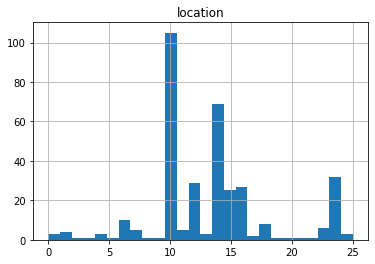

In [27]:
data = labelEncode(data, 'location')
data.hist(column='location', bins = 26)

In the histogram above it can be seen that there are more house sales in Cebu, followed by Lapu-Lapu, and Talisay.

### removing multicollinearity

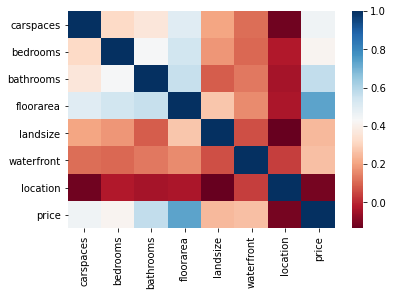

In [28]:
data = displayHeatMap(data)

In [29]:
displayVFI(data)

Current VFI


const         16.183422
carspaces      1.398423
bedrooms       1.479833
bathrooms      1.680119
floorarea      2.853908
landsize       1.127746
waterfront     1.081364
location       1.049324
price          2.573626
dtype: float64

In [30]:
displayDescribe(data)

,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,3.480000e+02
mean,1.999825,3.944979,3.556246,222.965878,345.903867,0.192529,13.344828,1.491804e+07
std,1.061521,1.900976,7.565497,224.249694,768.785899,0.394854,5.107665,2.059777e+07
min,0.000000,1.000000,1.000000,2.000000,35.000000,0.000000,0.000000,1.034000e+06
25%,1.000000,3.000000,2.000000,86.750000,98.750000,0.000000,10.000000,4.645750e+06
50%,1.991304,4.000000,3.000000,150.000000,160.000000,0.000000,14.000000,8.200000e+06
75%,2.000000,5.000000,4.000000,280.000000,319.750000,0.000000,15.000000,1.727500e+07
max,8.000000,18.000000,141.000000,2100.000000,10000.000000,1.000000,25.000000,2.000000e+08
+3_std,5.184389,9.647907,26.252738,895.714960,2652.261564,1.377090,28.667823,7.671134e+07
-3_std,-1.184739,-1.757949,-19.140246,-449.783204,-1960.453829,-0.992032,-1.978168,-4.687526e+07


In [31]:
data = removeOutliers(data)

Number of outliers found:  29


,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,2.0,2.0,3.0,150.0,173.0,1.0,14.0,3800000.0
1,1.0,3.0,2.0,80.0,291.0,1.0,1.0,7078000.0
2,5.0,3.0,2.0,385.4,1500.0,1.0,6.0,11900000.0
3,4.0,5.0,5.0,360.0,462.0,0.0,14.0,52000000.0
4,1.0,4.0,3.0,103.0,60.0,0.0,16.0,10500000.0
...,...,...,...,...,...,...,...,...
377,1.0,3.0,2.0,77.0,80.0,0.0,13.0,3111250.0
378,1.0,4.0,4.0,360.0,193.0,1.0,23.0,12000000.0
379,2.0,3.0,2.0,120.0,98.0,0.0,16.0,4800000.0
380,2.0,3.0,3.0,86.0,86.0,0.0,10.0,10000000.0


### Training Models

In [32]:
# instantiate models
modelLR = LinearRegression()
modelNN = MLPRegressor()
modelRF = RandomForestRegressor()
modelDT = DecisionTreeRegressor()

In [33]:
X = data.iloc[ : , 0:7]
Y = data.iloc[ : , 7]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

In [34]:
modelLR.fit(X_train, Y_train)
modelNN.fit(X_train, Y_train)
modelRF.fit(X_train, Y_train)
modelDT.fit(X_train, Y_train)

c:\users\ginn\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


DecisionTreeRegressor()

In [35]:
getScore("Linear Regression Model", modelLR)
getScore("Multi Layer Perceptron Model", modelNN)
getScore("Random Forest Regression Model", modelRF)
getScore("Decision Tree Regressor" ,modelDT)

Linear Regression Model
Train R-Squared:  0.6780464420819814
Test R-Squared:  0.633885458176024

Multi Layer Perceptron Model
Train R-Squared:  -0.9553323712166215
Test R-Squared:  -1.2834112904904127

Random Forest Regression Model
Train R-Squared:  0.9519396482963091
Test R-Squared:  0.6711206941617307

Decision Tree Regressor
Train R-Squared:  0.9999349880620259
Test R-Squared:  0.6200854217602801



### Identifying Errors

In [36]:
LRpred = modelLR.predict(X_test)
NNpred = modelNN.predict(X_test)
RFpred = modelRF.predict(X_test)
DTpred = modelDT.predict(X_test) 

In [37]:
getErrors("Linear Regression Model", LRpred)
getErrors("Multi Layer Perceptron Model", NNpred)
getErrors("Random Forest Regression Model", RFpred)
getErrors("Decision Tree Regressor", DTpred)

Linear Regression Model
Mean Squared Error (MSE):  42235372868114.086
Mean Absolute Error (MAE):  4414706.519876211
Root Mean Squared Error (RMSE):  6498874.7386077605

Multi Layer Perceptron Model
Mean Squared Error (MSE):  263416817001199.12
Mean Absolute Error (MAE):  12171452.149801979
Root Mean Squared Error (RMSE):  16230120.671184152

Random Forest Regression Model
Mean Squared Error (MSE):  37939875432110.44
Mean Absolute Error (MAE):  3979336.5181597224
Root Mean Squared Error (RMSE):  6159535.325989326

Decision Tree Regressor
Mean Squared Error (MSE):  43827360120815.79
Mean Absolute Error (MAE):  4409622.770833333
Root Mean Squared Error (RMSE):  6620223.57030454



### Decision Tree 

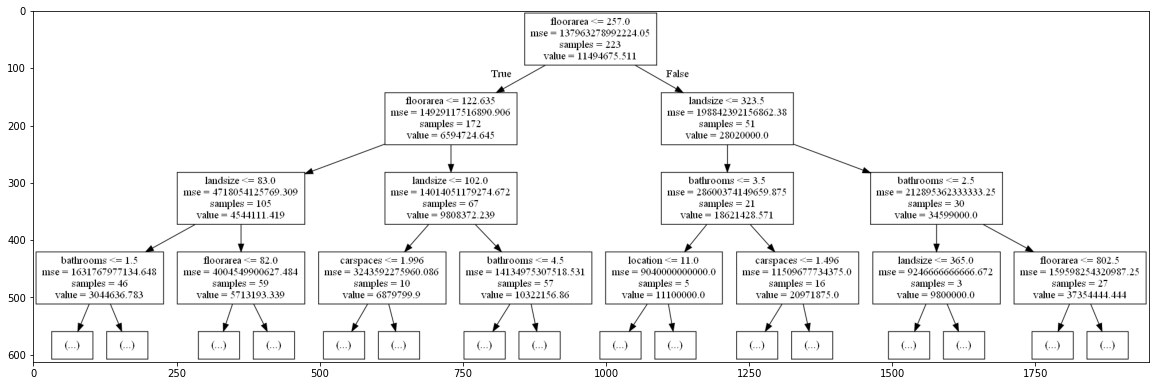

In [38]:
getDecisionTree(modelDT, list(data)[0:7])

### Determine Intercept and Coefficients

In [39]:
getInterceptCoeff(modelLR)


 The intercept for our model is -3.436e+06


,Coefficients
carspaces,5.569074e+05
bedrooms,-5.412178e+05
bathrooms,3.382220e+06
floorarea,3.174718e+04
landsize,3.919677e+03
waterfront,2.570202e+06
location,-1.067473e+05


In [40]:
# define our input
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

Bottom line: a negative R2 is not a mathematical impossibility or the sign of a computer bug. It simply means that the chosen model (with its constraints) fits the data really poorly.

### Test for Heterosecdasticity

In [41]:
checkHeterosecdasticity(est)

1.5729110840380287e-14 1.165269240088832e-16
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 1.573e-14
We reject the null hypothesis, so there is heterosecdasticity.


### Test for Autocorrelation

The number of lags will be 10
----------------------------------------------------------------------------------------------------
The lowest p-value found was 0.2948
We fail to reject the null hypothesis, so there is no autocorrelation.
----------------------------------------------------------------------------------------------------


c:\users\ginn\appdata\local\programs\python\python38\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


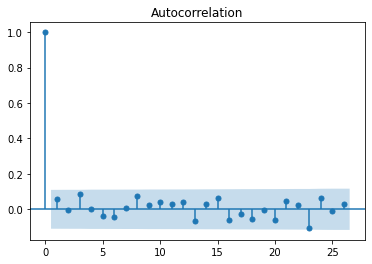

In [42]:
checkAutocorr(est, X)

In [43]:
getPredict(modelLR, X_test)

Price for the first 5 predictions: 
25301102.443769358
10021154.962202553
10823850.068096045
8053226.438811643
7176385.286571523


In [44]:
est.pvalues

const         1.946381e-02
carspaces     1.199619e-01
bedrooms      6.120807e-01
bathrooms     1.867905e-08
floorarea     2.779005e-17
landsize      3.592756e-02
waterfront    9.640726e-02
location      1.665043e-01
dtype: float64

In [45]:
# define our input
X2 = sm.add_constant(X)
X2 = X2.drop(['carspaces', 'bedrooms', 'waterfront', 'location'], axis = 1)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

In [46]:
est.pvalues

const        2.191318e-06
bathrooms    8.772925e-12
floorarea    2.077359e-18
landsize     7.104951e-03
dtype: float64

In [47]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     205.3
Date:                Sat, 20 Mar 2021   Prob (F-statistic):           8.80e-74
Time:                        23:29:58   Log-Likelihood:                -5464.9
No. Observations:                 319   AIC:                         1.094e+04
Df Residuals:                     315   BIC:                         1.095e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.641e+06   9.62e+05     -4.824      0.0

### Conclusion

In the accuracy of different models shown above, the random forest and decision tree models are overfitted. Thus, Linear Regression Model will be used but the accuracy is only 66%.

**Regression Equation:**

Price = -4,641,000 + 2,933,000 (bathrooms) + 35,150 (floorarea) + 4339.4346 (landsize)

Assuming a house for sale has 2 bathrooms, 51 sqm floor area, 98 sqm land size

In [48]:
price = -4641000 + 2933000*2 + 35150*51 + 4339.4346*98
price

3442914.5908